### Initialization Cells (ignore)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [2]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV

from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
#from sklearn.svm import SVC

from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

In [3]:
tdc = pd.read_csv('data_sets/wr_tdc_new.csv')

columns_floats = list(range(13,21)) +list(range(26,53)) +list(range(60,73)) +list(range(75,83)) + [85,92,93]
columns_nonnum = ['cfb conference','cfb class']

In [4]:
target = ['yards first 5 seasons']
inputs = ['cfb conference','cfb class','cfb games','cfb receptions',
          'cfb rec yards','cfb rec yards per reception','cfb rec td','cfb rush attempts',
          'cfb rush yards','cfb rush yards per attempt','cfb rush td','cfb scrimmages',
          'cfb yards','cfb yards from scrimmage','cfb td','combine ht','combine wt','combine forty',
          'combine vertical','combine benchreps','combine broadjump','combine cone','combine shuttle']

new_tdc = tdc[inputs+target]
ntdc = new_tdc.rename(columns={
    'cfb conference':'cfbconference',
    'cfb class':'cfbclass',
    'cfb games':'cfbgames',
    'cfb receptions':'cfbreceptions',
    'cfb rec yards':'cfbrecyards',
    'cfb rec yards per reception':'cfbrecyardsperreception',
    'cfb rec td':'cfbrectd',
    'cfb rush attempts':'cfbrushattempts',
    'cfb rush yards':'cfbrushyards',
    'cfb rush yards per attempt':'cfbrushyardsperattempt',
    'cfb rush td':'cfbrushtd',
    'cfb scrimmages':'cfbscrimmages',
    'cfb yards': 'cfbyards',
    'cfb yards from scrimmage':'cfbyardsfromscrimmage',
    'cfb td':'cfbtd',
    'combine ht':'combineht',
    'combine wt':'combinewt',
    'combine forty':'combineforty',
    'combine vertical':'combinevertical',
    'combine benchreps':'combinebenchreps',
    'combine broadjump':'combinebroadjump',
    'combine cone':'combinecone',
    'combine shuttle':'combineshuttle',
    'yards first 5 seasons':'yardsfirst5seasons'})

In [5]:
ntdc.to_csv('data_sets/wr.csv',index = False)

In [5]:
def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()

## Summary

This data set is pretty difficult and most importantly... limited. For recall, our target is **y = yards first 5 seasons** and we have a total of **23 input variables**, 2 of them are non-numerical. But unfortunately, we only have a total of **393 data points** and only roughly 75% of it is complete - 300/ 393 to be exact. If you account for non specified values for the discrete features, this number even drops to 273/393...

Also, very noticeably, or data is very spread out. A lot of players end up having 0 play time in the NFL, sometimes because of lack of competitiveness or because of injuries, despite very satisfying performances in college football. For example, as indicated by the very first figure in this notebook, the total number of TD in college (the variable which correlates the most with **y**) has an impact on most of player's NFL performances, but for a substantial number of them, it doesn't: $y = 0$. This observation is mostly the reason for the difficulty of building a predictable model. Hence, most of this notebook will consist in studying how keeping or removing certain sets of data improve or worsen the model. We will also explore how varying certain parameters can affect the performance of our algorithm.

As we attempt multiple supervised machine learning models on our data set, for each attempt, we will compute the coefficient of determination $R^2$ and very importantly, the root-mean-square deviation $RMSE$ which we'll look to minimize. We will do using a cross validation with 10 folds and pick out the average values returned for each of those metrics.

# 1st attempt - All the data - Remove 'Nan' entries
We first remove the non-crucial combine data such as vertical, benchreps, broadjump, cone and shuttle stats. Those have very little importance in a player's overall combine performance, and a lot of them have null entries, suggesting the players do not attempt those tests:

- We start with running a simple linear regression model between our target **y** and the number of TD in college **X =  cfb td**
- We then run the same on all input numerical variables **X**
- Finally we run a simple Train/Test split on our data and do a cross validation test which returns the coefficient of fitness $R^2$ and the root mean square error $RMSE$

In [279]:
ntdc[['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 5 columns):
combinevertical     245 non-null float64
combinebenchreps    85 non-null float64
combinebroadjump    234 non-null float64
combinecone         194 non-null float64
combineshuttle      198 non-null float64
dtypes: float64(5)
memory usage: 15.5 KB


As we can see above, there are far too many null entries for those variables, hence we remove them.

In [78]:
wr1=ntdc.drop(['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle'],axis = 1)
wr1d = wr1.dropna()

### Linear regression model with one imput: CFB TD (using statsmodel)

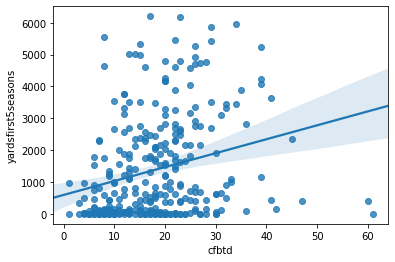

In [80]:
_ = sns.regplot(y="yardsfirst5seasons", x="cfbtd", data=wr1d, fit_reg = True)

The existence of all these data points, narroweed to the x-axis indicate that a substantial amount of players end up with no playing time in the NFL, despite scoring a relatively high number of TDs in college.

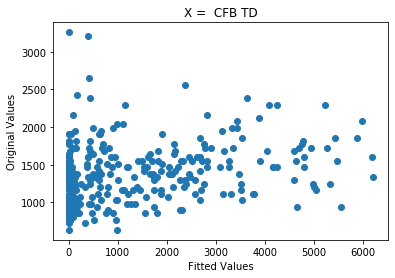

In [49]:
m = ols('yardsfirst5seasons ~ cfbtd',wr1d).fit()
#print(m.summary())
plt.scatter(wr1d.yardsfirst5seasons, m.fittedvalues)
plt.xlabel('Original Values for y')
plt.ylabel('Fitted Values for y')
plt.title('X =  CFB TD')
plt.show()

### Linear Regression: all variables (using sklearn)

In [81]:
# We pick all numerical variables (except our target) as our feature data: X
X = wr1d.drop(['cfbconference','cfbclass','yardsfirst5seasons'], axis = 1)
y = wr1d['yardsfirst5seasons']

# Instiantate the regressor
reg = LinearRegression()

# Fit to the data
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

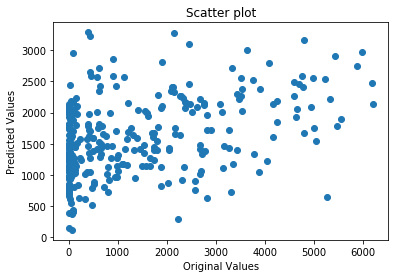

R^2: 0.15049769386941025
Root Mean Squared Error: 1463.5172332057991
Given that the target y ranges from -1.0 to 6201.0


In [88]:
# print('Number of coefficients: {}'.format(len(lm.coef_)))
# pd.DataFrame({'features': X.columns, 'estimatedCoefficients': lm.coef_})[['features', 'estimatedCoefficients']]

# Predict the data
y_pred = reg.predict(X)

plt.scatter(y, y_pred)
plt.xlabel('Original Values')
plt.ylabel('Predicted Values')
plt.title('Scatter plot')
plt.show()

print("R^2: {}".format(reg.score(X, y)))
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))
print("Given that the target y ranges from %.1f to %.1f"%(min(y), max(y)))

### Linear Regression and Train/Test Split (using sklearn)

In [53]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# Returning those quantities with a CV test
cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))

print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

R^2: 0.10794418303737265
Root Mean Squared Error: 1355.5862327786126
Average R^2 after 10 CV tests: -0.012390839850721657
Average RMSE after 10 CV tests: 1515.6908625638291


# 2nd attempt - Data that correlates the most

Here, we first decide to pick those input variables that correlate the most with our target, which we deem critical to our study. The idea in doing so is to potentially get rid of useless features. From there, we can also:

- remove outrageous outliers using statsmodels
- then, rather than doing a train/test split model, we do the cross validation test using the updated data set

In [54]:
wr2 = ntdc[['cfbrectd', 'cfbtd', 'cfbyards', 'cfbrecyards','cfbyardsfromscrimmage','cfbgames','yardsfirst5seasons']]
wr2d = wr2.dropna().reset_index(drop = True)

### Statsmodels: Remove outrageous outliers

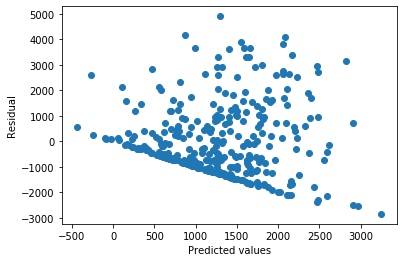

R^2: 0.1677280098276569
Root Mean Squared Error: 1410.657872434383


In [55]:
m = ols('yardsfirst5seasons ~ cfbrectd + cfbtd + cfbyards + cfbrecyards + cfbyardsfromscrimmage + cfbgames',wr2d).fit()
#print(m.summary())

y_pred = m.fittedvalues
y = wr2d.yardsfirst5seasons

plt.scatter(y_pred, y - y_pred)
plt.xlabel('Predicted values')
plt.ylabel('Residual')
plt.show()

print("R^2:",m.rsquared)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

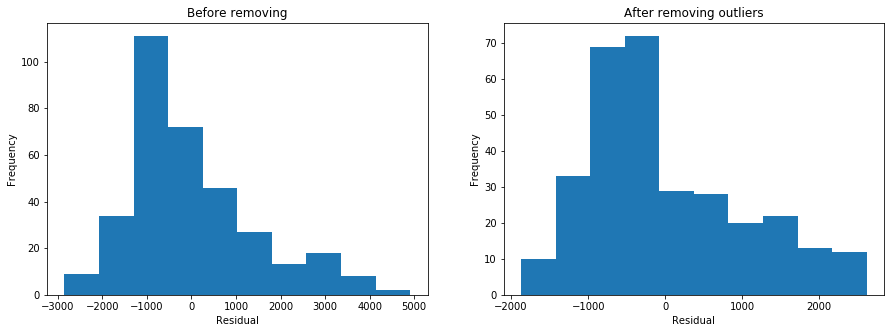

R^2: 0.1777428574040465
Root Mean Squared Error: 1006.9354576943266


In [56]:
high_resid = np.where(abs(m.resid) > 2500)
#high_studentized_resid = np.where(abs(m.get_influence().resid_studentized_external > 2.5))
wr2d_new = wr2d.drop(high_resid[0], axis = 0)
m_new = ols('yardsfirst5seasons ~ cfbrectd + cfbtd + cfbyards + cfbrecyards + cfbyardsfromscrimmage + cfbgames',wr2d_new).fit()

_ = plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(m.resid)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Before removing')

plt.subplot(1,2,2)
plt.hist(m_new.resid)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('After removing outliers')
plt.show()

y_pred = m_new.fittedvalues
y = wr2d_new.yardsfirst5seasons
print("R^2:",m_new.rsquared)
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

Note that the residual are (sadly) **not** normally distributed

### Sklearn: Linear Regression on Train/Test split of the new data set

Before removing the outrageous outliers

In [57]:
X = wr2d[['cfbrectd', 'cfbtd', 'cfbyards', 'cfbrecyards','cfbyardsfromscrimmage','cfbgames']]
y = wr2d['yardsfirst5seasons']

reg = LinearRegression()

cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average R^2 after 10 CV tests: 0.08351104051281576
Average RMSE after 10 CV tests: 1437.9412262761098


Now, removing the outrageous outliers

In [58]:
wr2_new = wr2.drop(high_resid[0], axis = 0)
wr2d_new = wr2_new.dropna().reset_index(drop = True)
X = wr2d_new[['cfbrectd', 'cfbtd', 'cfbyards', 'cfbrecyards','cfbyardsfromscrimmage','cfbgames']]
y = wr2d_new['yardsfirst5seasons']

reg = LinearRegression()

cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average R^2 after 10 CV tests: 0.10362786640559651
Average RMSE after 10 CV tests: 1363.658541637911


# 3rd Attempt: Non-numerical Data

We will now look to include the conference and class data to our data set of the 2nd attempt and see if we notice any improvement in the coefficient of fitness $R^2$ or the $RMSE$.

To do so, we use the pandas function *get_dummies* which each non-numerical value into a set of multiple binary-valued columns. As we've done up until now, we remove all rows that do not have a specific value for those variables: they are set as *'Other'* for the conference and *'Non Declared'* for the CFB class.

In [59]:
wr3 = ntdc[['cfbconference','cfbclass','cfbrectd', 'cfbtd','cfbyards', 
            'cfbrecyards','cfbyardsfromscrimmage','cfbgames','yardsfirst5seasons']].drop(high_resid[0], axis = 0)
wr3d = wr3.dropna().reset_index(drop = True)

# Remove rows that contain either 'Other' or 'Non Declared'
cond = wr3d[wr3d.cfbconference == 'Other'] | wr3d[wr3d['cfbclass'] == 'Non Declared']
wr3d = wr3d.drop(cond.index, axis = 0)

wr3d_new = pd.get_dummies(wr3d, prefix=['cfbconference','cfbclass'])

In [60]:
X = wr3d_new.drop('yardsfirst5seasons', axis = 1)
y = wr3d_new['yardsfirst5seasons']

reg = LinearRegression()

cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average R^2 after 10 CV tests: 0.02271017635935817
Average RMSE after 10 CV tests: 1402.011567084106


Unfortunately, we do not see a neat improvement in the minimization of the error of our model by accounting for the conference or the class of the player upon entry in the draft.

# 4th Attempt: Handling Missing values

Let's now consider models that will handle missing values. Up until now, we've simply removed all rows that contained a single np.nan entry in the feature variable (93/393 rows total).

Using our data set from the 1st attempt (all data, except useless combine stats), let's attempt to repeat the process of our 3rd attempt. We set the missing cfbconference and cfbclass data as np.nan as well, so that the **imputer**, whose strategy is based off the **mean value** of the existing data, handles those too. 

At first, we do not consider the columns of cfbconference / cfbclass, but we do so in the later part.

### Remove cfbconference and cfbclass from our feature data X

In [62]:
wr4=ntdc.drop(['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle'],axis = 1)
X = wr4.drop(['yardsfirst5seasons','cfbconference','cfbclass'],axis = 1)
y = wr4['yardsfirst5seasons']

# Instantiate an instance of the imputer based on a 'mean' strategy
imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)

reg = LinearRegression()

cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average R^2 after 10 CV tests: 0.08034193903762929
Average RMSE after 10 CV tests: 1394.910146346188


### Include cfbconference and cfbclass to our feature data X using Pandas get_dummies

In [63]:
wr4=ntdc.drop(['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle'],axis = 1)
wr4.loc[wr4.cfbconference == 'Other','cfbconference'] = np.nan
wr4.loc[wr4.cfbclass == 'Non Declared','cfbclass'] = np.nan

wr4_new = pd.get_dummies(wr4, prefix=['cfbconference','cfbclass'])

In [65]:
X = wr4_new.drop('yardsfirst5seasons',axis = 1)
y = wr4_new['yardsfirst5seasons']

imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)

reg = LinearRegression()

cv_scores = cross_validate(reg, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average R^2 after 10 CV tests:', np.mean(cv_scores['test_r2']))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average R^2 after 10 CV tests: 0.0946038934301788
Average RMSE after 10 CV tests: 1383.1872617298595


# 5th Attempt: Regularization with Ridge

We attempt to do regularization with **Ridge** manually and through a CV grid. The CV grid is advantageous in that it can easily fit the **$\alpha$** parameter in our model and return best fit solution with respect to the **cv score**. Nevertheless, our model's tuning, up until now, has been based on the $R^2$ and most importantly, on the **RSME**.

- Therefore, at first, we will simply run the cross validation scores over a range of $\alpha$ parameters (spanned over a log scale) and return the minimum value (along with a plot of those scores)
- Then, we will repeat the process but this time over the $RSME$ metric instead

### CV Scores

In [66]:
wr5=ntdc.drop(['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle'],axis = 1)

wr5.loc[wr5.cfbconference == 'Other','cfbconference'] = np.nan
wr5.loc[wr5.cfbclass == 'Non Declared','cfbclass'] = np.nan
wr5d = wr5.dropna().reset_index(drop = True)
wr5d = pd.get_dummies(wr5d, prefix=['cfbconference','cfbclass'])

# wr5 = wr5.drop(['cfbconference','cfbclass'], axis = 1)
# wr5d = wr5.dropna().reset_index(drop = True)

X = wr5d.drop('yardsfirst5seasons',axis = 1)
y = wr5d['yardsfirst5seasons']

Tuned Linear Regression Parameters: {'alpha': 0.8286427728546842}
Best score is 0.11858098159703248


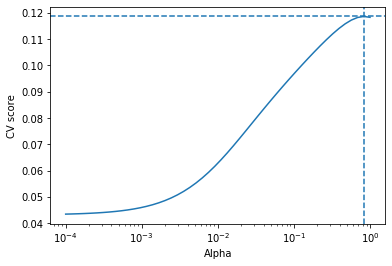

In [67]:
# Setup the hyperparameter grid
alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}

# Instantiate the GridSearchCV object
ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=5)
reg_cv.fit(X, y)

# Return the best score and best parameter
print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

# We can also plot the score by taking the average of it for each parameter alpha
ridge_scores = []
ridge_scores_std = []

for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 5)
    ridge_scores.append(np.mean(ridge_cv_scores))    
    ridge_scores_std.append(np.std(ridge_cv_scores))

plt.plot(alpha_space, ridge_scores)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("CV score")
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(reg_cv.best_score_, linestyle = '--')
plt.show()

### RMSE

Tuned Linear Regression Parameters: {'alpha': 0.8286427728546842}
Best score is 1449.158698872408


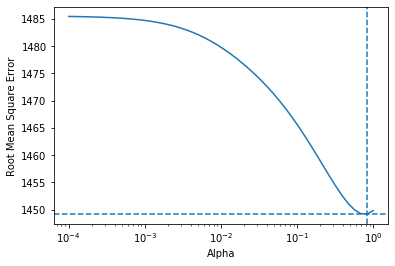

In [68]:
alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}
ridge_rmse = []

ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=10, scoring= 'neg_root_mean_squared_error', refit = False)
reg_cv.fit(X, y)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(-reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_validate(ridge, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))   
    ridge_rmse.append(-np.mean(ridge_cv_scores['test_neg_root_mean_squared_error']))
    
plt.plot(alpha_space, ridge_rmse)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel('Root Mean Square Error')
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(-reg_cv.best_score_, linestyle = '--')
plt.show()

In [ ]:
# And then with a pipeline

#steps = [('imputation', Imputer(missing_values=np.nan, strategy='most_frequent')),
        # ('scaler', StandardScaler()),
        # ('linear_regression', LinearRegression())] or          ('elasticnet', ElasticNet())]
#pipeline = Pipeline(steps)

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = .3)
#pipeline.fit(X_train, y_train)
#y_pred = pipeline.predict(X_test)

# Parameter Space
# parameters = {'elasticnet__l1_ratio':np.linspace(0,1,30)}

# Compute metrics

#gm_cv = GridSearchCV(pipeline, parameters, cv = 3)
#gm_cv.fit(X_train, y_train)

#r2 = gm_cv.score(X_test, y_test)
#print("Tuned ElasticNet Alpha: {}".format(gm_cv.best_params_))
#print("Tuned ElasticNet R squared: {}".format(r2))

# 6th Attempt: Normalization, QuantileTransformer, Squaring of $Y_i$'s

In a last attempt to tune our model even more, we suggest two additional methods:
- normalization of all data both **X** and **y**
- search for a potential nonlinear behavior between our metric **y** and the feature variable that correlates the most **X = cfbtd**. For this, we also operate under normalization

Since both methods change the scaling of our residual, it becomes quite hard to compare the effectiveness of our model on our *transformed* data based on the $RMSE$ for example. Instead, we will compute the cv score, as we did in the first step on the 5th attempt and compare it respectively

In [96]:
wr6=ntdc.drop(['combinevertical','combinebenchreps','combinebroadjump','combinecone','combineshuttle'],axis = 1)

wr6.loc[wr6.cfbconference == 'Other','cfbconference'] = np.nan
wr6.loc[wr6.cfbclass == 'Non Declared','cfbclass'] = np.nan
wr6d = wr6.dropna().reset_index(drop = True)
wr6d = pd.get_dummies(wr6d, prefix=['cfbconference','cfbclass'])

### Normalization using StandardScaler

In [97]:
X = wr6d.drop('yardsfirst5seasons',axis = 1)
y = wr6d['yardsfirst5seasons']

x = X.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_new = pd.DataFrame(x_scaled)
X_new.columns = X.columns.tolist()

Tuned Linear Regression Parameters: {'alpha': 0.8286427728546842}
Best score is 0.1185809815970326


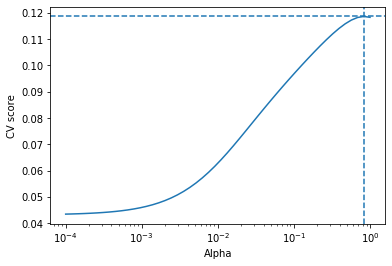

In [99]:
X = X_new

alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}

ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=5)
reg_cv.fit(X, y)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

ridge_scores = []
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 5)
    ridge_scores.append(np.mean(ridge_cv_scores))    

plt.plot(alpha_space, ridge_scores)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("CV score")
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(reg_cv.best_score_, linestyle = '--')
plt.show()

### Squaring cfbtd and Normalization using StandardScaler

In [72]:
wr6d.cfbtd = np.square(wr6d.cfbtd)
x = wr6d.values
min_max_scaler = preprocessing.StandardScaler()
x_scaled = min_max_scaler.fit_transform(x)
wr6d_new = pd.DataFrame(x_scaled)
wr6d_new.columns = wr6d.columns.tolist()

X = wr6d_new.drop('yardsfirst5seasons',axis = 1)
y = wr6d_new['yardsfirst5seasons']

Tuned Linear Regression Parameters: {'alpha': 0.6866488450042998}
Best score is 0.1119597443275104


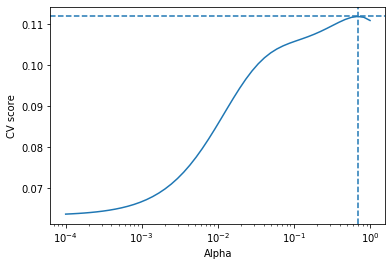

In [73]:
alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}

ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=5)
reg_cv.fit(X, y)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

ridge_scores = []
for alpha in alpha_space:
    ridge.alpha = alpha
    ridge_cv_scores = cross_val_score(ridge, X, y, cv = 5)
    ridge_scores.append(np.mean(ridge_cv_scores))    

plt.plot(alpha_space, ridge_scores)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel("CV score")
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(reg_cv.best_score_, linestyle = '--')
plt.show()

# OUR FINAL CHOICE FOR OUR DATA AND MODEL

Throughout this notebook, we hoped to design a predictive model based on the collegiate and combine performances, which, when fed a particular data set, would return stasifying prognostics on the number of yards by a drafted WR during its first 5 years in the NFL. Unfortunately, we weren't able to come up with satisfactory results. 

Still, we were able to test how narrowing down or expanding our data set would affect the ability of the model to reduce the error in its predictions. Our method to test the tuning of our model was identical throughout each attempt: considering the feature data X and target y, we would design a Linear Regression model on 70% of the data and test it against the 30%. The metric which we cared for principaly was the root mean square error on the the split data, averaged over 10 cross validation tests. We noted the following:
- When reducing all features variables to the 5 most essential (namely X'), we were able to reduce the root mean square error  from $RMSE = 1515.6908$ to $RMSE = 1437.9412$
- When removing outliers (data points whose $RMSE > 2,500$ on the complete data based linear regression model), we were even able to reduce that number to $RMSE = 1363.6585$
- When considering the features X' but also the non-numerical variables, we unfortunately did not observe a reduction in the residual.
- However, when applying an imputer with mean value based strategy to handle the missing data, even by including the non-numerical features, we were able to find a modest $RMSE = 1383.1872$

But making variations of the data wasn't our only objective, we also used the Ridge Linear Regressor to build our regression model. The strategy was to be able to minimize the residual or improving the cv score by tuning the $\alpha$ parameter of the regressor. We did so in two different circumstances:
- with our original data (without the imputer): we found the RMSE to drop to $RMSE = 1449.1586$ for $\alpha = 0.8286$ (the cv score would then be $score = 0.118580$.
- with our normalized data, while also considering the square of the number of TD's as a feature variable, we found this cv score to remain stagnant $score = 0.11195$ (note here, the best parameter for $\alpha$ was then $\alpha = 0.68664$)

### In summary, our final model consists of:
- choosing the most important features X' along with the non-numerical variables (conference and class)
- remove the outliers
- applying an imputer with mean value based strategy to handle the missing data
- run a ridge linear algorithm

Tuned Linear Regression Parameters: {'alpha': 0.47148663634573895}
Best score is 1350.64635116853


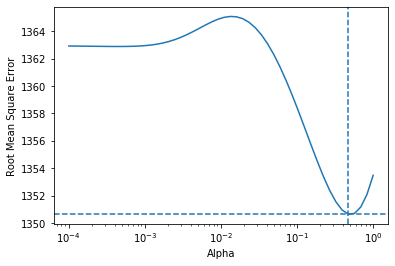

In [74]:
wrf = ntdc[['cfbconference','cfbclass','cfbrectd', 'cfbtd','cfbyards', 
            'cfbrecyards','cfbyardsfromscrimmage','cfbgames','yardsfirst5seasons']].drop(high_resid[0], axis = 0)
wrf.loc[wrf.cfbconference == 'Other','cfbconference'] = np.nan
wrf.loc[wrf.cfbclass == 'Non Declared','cfbclass'] = np.nan
wrf = pd.get_dummies(wrf, prefix=['cfbconference','cfbclass'])

# Remove the outliers from the 2nd attempt
#wrf= wrf.drop(high_resid[0], axis = 0).reset_index(drop = True)


X = wrf.drop('yardsfirst5seasons',axis = 1)
y = wrf['yardsfirst5seasons']
imp = Imputer(missing_values= np.nan, strategy = 'mean')
imp.fit(X)
X = imp.transform(X)

alpha_space = np.logspace(-4, 0, 50)
param_grid = {'alpha': alpha_space}

ridge = Ridge(normalize = True)
reg_cv = GridSearchCV(ridge, param_grid, cv=10, scoring= 'neg_root_mean_squared_error', refit = False)
reg_cv.fit(X, y)

print("Tuned Linear Regression Parameters: {}".format(reg_cv.best_params_)) 
print("Best score is {}".format(-reg_cv.best_score_))
alpha_best = reg_cv.best_params_['alpha']

ridge_rmse = []
for alpha in alpha_space:
    ridge.alpha = alpha   
    ridge_cv_scores = cross_validate(ridge, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))   
    ridge_rmse.append(-np.mean(ridge_cv_scores['test_neg_root_mean_squared_error']))
    
plt.plot(alpha_space, ridge_rmse)
plt.xscale("log")
plt.xlabel("Alpha")
plt.ylabel('Root Mean Square Error')
plt.axvline(alpha_best, linestyle = '--')
plt.axhline(-reg_cv.best_score_, linestyle = '--')
plt.show()

In [75]:
ridge = Ridge(normalize = True)
ridge.alpha = alpha_best

cv_scores = cross_validate(ridge, X, y, cv = 10, scoring=('r2', 'neg_root_mean_squared_error'))
print('Average RMSE after 10 CV tests:', -np.mean(cv_scores['test_neg_root_mean_squared_error']))

Average RMSE after 10 CV tests: 1350.64635116853


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error for a random train/test split: {}".format(rmse))

Root Mean Squared Error for a random train/test split: 1323.0469520732267
